In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_absolute_error
from sklearn.feature_extraction import DictVectorizer
from prophet import Prophet
import xgboost as xgb
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX 

/home/rogue-one/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Prepare Dataset

In [2]:
data_df = pd.read_csv('Data.csv',sep=',')

In [3]:
df = data_df.sample(1000000).reset_index()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 11 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   index              1000000 non-null  int64  
 1   date_time          1000000 non-null  object 
 2   v_red              353131 non-null   float64
 3   current            1000000 non-null  float64
 4   power_factor       1000000 non-null  float64
 5   kwh                1000000 non-null  float64
 6   Source             1000000 non-null  object 
 7   v_blue             313244 non-null   float64
 8   v_yellow           333625 non-null   float64
 9   consumer_device_9  1000000 non-null  int64  
 10  consumer_device_x  1000000 non-null  int64  
dtypes: float64(6), int64(3), object(2)
memory usage: 83.9+ MB


In [5]:
df_climate = pd.read_excel('climate_data/Kalam Climate Data.xlsx')
df_climate

,Date Time,Temperature (°C),Dewpoint Temperature (°C),U Wind Component (m/s),V Wind Component (m/s),Total Precipitation (mm),Snowfall (mm),Snow Cover (%)
0,2023-06-03 13:00:00,7.199731,-2.448126,-0.034195,0.060989,0.000377,0.000000,99.972656
1,2023-06-03 14:00:00,6.000620,-2.597540,-0.080688,0.018585,0.000398,0.000000,99.972656
2,2023-06-03 15:00:00,4.789972,-2.696951,0.057449,-0.352020,0.000418,0.000000,99.972656
3,2023-06-03 16:00:00,3.158746,-2.879324,0.051529,-0.608948,0.000420,0.000000,99.972656
4,2023-06-03 17:00:00,1.671426,-3.255606,0.056137,-0.739838,0.000420,0.000000,99.972656
...,...,...,...,...,...,...,...,...
12223,2024-10-24 20:00:00,-5.387305,-5.942435,0.045059,-1.108795,0.000394,0.000129,7.855469
12224,2024-10-24 21:00:00,-6.008307,-6.837256,0.015198,-1.194077,0.000395,0.000129,7.859375
12225,2024-10-24 22:00:00,-6.535742,-7.863989,-0.028015,-1.230438,0.000397,0.000129,7.863281
12226,2024-10-24 23:00:00,-6.864859,-8.328970,-0.058334,-1.272537,0.000399,0.000130,7.871094


In [6]:
df_climate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12228 entries, 0 to 12227
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date Time                  12228 non-null  datetime64[ns]
 1   Temperature (°C)           12228 non-null  float64       
 2   Dewpoint Temperature (°C)  12228 non-null  float64       
 3   U Wind Component (m/s)     12228 non-null  float64       
 4   V Wind Component (m/s)     12228 non-null  float64       
 5   Total Precipitation (mm)   12228 non-null  float64       
 6   Snowfall (mm)              12228 non-null  float64       
 7   Snow Cover (%)             12228 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 764.4 KB


# Data Preprocessing

In [7]:
df.columns = df.columns.str.lower()

In [8]:
df_climate.columns = df_climate.columns.str.lower().str.replace('(','').str.replace(')','').str.replace(' ','_')

## Energy data preprocessing

In [9]:
df.columns

Index(['index', 'date_time', 'v_red', 'current', 'power_factor', 'kwh',
       'source', 'v_blue', 'v_yellow', 'consumer_device_9',
       'consumer_device_x'],
      dtype='object')

In [10]:
df.date_time = pd.to_datetime(df.date_time)

In [11]:
# phase type classification
df['phase_type'] = np.where(
    (df['v_blue'].notna() & df['v_blue'] != 0.0) |
    (df['v_yellow'].notna() & df['v_yellow'] != 0.0),
      'three_phase','single_phase')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 12 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   index              1000000 non-null  int64         
 1   date_time          1000000 non-null  datetime64[ns]
 2   v_red              353131 non-null   float64       
 3   current            1000000 non-null  float64       
 4   power_factor       1000000 non-null  float64       
 5   kwh                1000000 non-null  float64       
 6   source             1000000 non-null  object        
 7   v_blue             313244 non-null   float64       
 8   v_yellow           333625 non-null   float64       
 9   consumer_device_9  1000000 non-null  int64         
 10  consumer_device_x  1000000 non-null  int64         
 11  phase_type         1000000 non-null  object        
dtypes: datetime64[ns](1), float64(6), int64(3), object(2)
memory usage: 91.6+ MB


In [13]:
#kwh conversion to numeric
df['kwh'] = pd.to_numeric(df.kwh,errors='coerce')

In [14]:
#Extract user ID from the source column
df[['consumer_device_id','user_id']] = df['source'].str.extract(r'consumer_device_(\d+)_data_user_(\d+)')

In [ ]:
#convert ids to numeric
df.user_id = pd.to_numeric(df.user_id)
df.consumer_device_id = pd.to_numeric(df.consumer_device_id)

In [32]:
# del df['consumer_device_9']
# del df['consumer_device_x']

In [16]:
#normalize power and voltage features

df['voltage_avg'] = df.apply(lambda row: np.nanmean([
    row['v_red'] if pd.notna(row['v_red']) else 0,
    row['v_blue'] if pd.notna(row['v_blue']) else 0,
    row['v_yellow'] if pd.notna(row['v_yellow']) else 0,
]), axis=1)

In [17]:
# calculate apparent power(va)
df['apparent_power'] = df['voltage_avg']*df['current']

In [29]:
# calculation of real power (W) using power factor
df['real_power'] = df['apparent_power']*df['power_factor']

In [39]:
df.columns

Index(['index', 'date_time', 'v_red', 'current', 'power_factor', 'kwh',
       'source', 'v_blue', 'v_yellow', 'phase_type', 'consumer_device_id',
       'user_id', 'voltage_avg', 'apparent_power', 'real_power'],
      dtype='object')

In [41]:
# Aggregate to daily consumption per day
daily_energy = df.groupby(['user_id',pd.Grouper(key='date_time', freq='D')]).agg({
    'kwh':'sum',
    'current':'mean',
    'power_factor':'mean',
    'voltage_avg':'mean',
    'apparent_power':'mean',
    'real_power':'mean',
    'phase_type':'first',
    'consumer_device_id':'first',
})
daily_energy

kwh   current  power_factor  voltage_avg  \
user_id date_time                                                   
1       2023-06-03  0.000000  0.000000      0.000000     0.000000   
        2023-06-04  0.000000  0.000000      0.000000     0.000000   
        2023-06-05  0.000000  0.000000      0.000000     0.000000   
        2023-06-06  0.000000  0.000000      0.000000     0.000000   
        2023-06-07  0.000000  0.000000      0.000000     0.000000   
...                      ...       ...           ...          ...   
21      2024-09-19  0.007189  0.082857      0.755714    65.489048   
        2024-09-20  0.005540  0.073333      0.621667    56.307222   
        2024-09-21  0.008974  0.075000      0.677000    57.156667   
        2024-09-22  0.006324  0.052000      0.447000    39.119667   
        2024-09-23  0.000996  0.080000      0.760000    65.553333   

                    apparent_power  real_power    phase_type  \
user_id date_time                                              
1       2023-06-03        0.000000    0.000000  single_phase   
        2023-06-04        0.000000    0.000000  single_phase   
        2023-06-05        0.000000    0.000000  single_phase   
        2023-06-06        0.000000    0.000000  single_phase   
        2023-06-07        0.000000    0.000000  single_phase   
...                            ...         ...           ...   
21      2024-09-19        5.430767    4.107999   three_phase   
        2024-09-20        4.954017    3.693565   three_phase   
        2024-09-21        4.768530    3.589666   three_phase   
        2024-09-22        3.390207    2.529483   three_phase   
        2024-09-23        5.244267    3.985643   three_phase   

                    consumer_device_id  
user_id date_time                       
1       2023-06-03                   3  
        2023-06-04                   3  
        2023-06-05                   3  
        2023-06-06                   3  
        2023-06-07                   3  
...                                ...  
21      2024-09-19                  32  
        2024-09-20                  32  
        2024-09-21                  32  
        2024-09-22                  32  
        2024-09-23                  32  

[9488 rows x 8 columns]

## Climate data preprocessing

In [42]:
df_climate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12228 entries, 0 to 12227
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date_time                12228 non-null  datetime64[ns]
 1   temperature_°c           12228 non-null  float64       
 2   dewpoint_temperature_°c  12228 non-null  float64       
 3   u_wind_component_m/s     12228 non-null  float64       
 4   v_wind_component_m/s     12228 non-null  float64       
 5   total_precipitation_mm   12228 non-null  float64       
 6   snowfall_mm              12228 non-null  float64       
 7   snow_cover_%             12228 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 764.4 KB


In [44]:
#resample to daily_data
climate_daily = df_climate.resample('D', on='date_time').agg(
    {
        'temperature_°c':'mean',
        'dewpoint_temperature_°c':'mean',
        'u_wind_component_m/s':'mean',
        'v_wind_component_m/s': 'mean',
        'total_precipitation_mm':'sum',
        'snowfall_mm':'sum',
        'snow_cover_%':'mean'
    }).reset_index()

In [45]:
climate_daily

,date_time,temperature_°c,dewpoint_temperature_°c,u_wind_component_m/s,v_wind_component_m/s,total_precipitation_mm,snowfall_mm,snow_cover_%
0,2023-06-03,1.860280,-3.348664,0.025054,-0.657726,0.004557,0.000000e+00,99.972656
1,2023-06-04,3.992740,-1.905203,-0.180909,-0.505298,0.024096,0.000000e+00,99.972656
2,2023-06-05,4.794523,-3.781657,-0.145114,-0.498183,0.011580,1.166000e-06,99.972656
3,2023-06-06,6.304390,-4.670615,0.018054,-0.478623,0.008914,5.220000e-08,99.972656
4,2023-06-07,7.003922,-3.965763,0.083701,-0.516598,0.008649,0.000000e+00,99.972656
...,...,...,...,...,...,...,...,...
506,2024-10-21,3.712101,-3.217974,-0.118125,-0.373651,0.008551,0.000000e+00,1.033285
507,2024-10-22,2.515382,-2.358298,0.047106,-0.214380,0.010362,1.610100e-04,0.531738
508,2024-10-23,0.315618,-0.711822,0.001728,-0.227600,0.056409,2.708602e-02,6.653727
509,2024-10-24,-0.349515,-1.964442,0.045428,-0.506269,0.010772,4.633883e-03,9.877035


#### Humidity index
The humidex (short for humidity index) is an index number used by Canadian meteorologists to describe how hot the weather feels to the average person, by combining the effect of heat and humidity. 

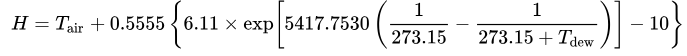

In [46]:
# Humid index calculas
e = 6.11*np.exp(5417.7530*((1/273.15) - (1/climate_daily['dewpoint_temperature_°c']+273.15)))
h = (0.5555)*(e-10.0)

climate_daily['humidex'] = climate_daily['temperature_°c'] + h

In [48]:
climate_daily.head()

,date_time,temperature_°c,dewpoint_temperature_°c,u_wind_component_m/s,v_wind_component_m/s,total_precipitation_mm,snowfall_mm,snow_cover_%,humidex
0,2023-06-03,1.860280,-3.348664,0.025054,-0.657726,0.004557,0.000000e+00,99.972656,-3.694720
1,2023-06-04,3.992740,-1.905203,-0.180909,-0.505298,0.024096,0.000000e+00,99.972656,-1.562260
2,2023-06-05,4.794523,-3.781657,-0.145114,-0.498183,0.011580,1.166000e-06,99.972656,-0.760477
3,2023-06-06,6.304390,-4.670615,0.018054,-0.478623,0.008914,5.220000e-08,99.972656,0.749390
4,2023-06-07,7.003922,-3.965763,0.083701,-0.516598,0.008649,0.000000e+00,99.972656,1.448922


In [ ]:
# heating degrees days (HDD) and coolong degree days (CDD)
base_temp = 18.0
climate_daily['HDD'] = np.maximum(0,base_temp - climate_daily['temperature_°c'])
climate_daily['CDD'] = np.maximum(0,climate_daily['temperature_°c'] - base_temp)

In [23]:
# windspeed calculation
climate_daily['wind_speed'] = np.sqrt(
    climate_daily['u_wind_component_m/s']**2+climate_daily['v_wind_component_m/s']**2
)

In [25]:
# Merge datasets
merged_df = pd.merge(
    daily_energy,
    climate_daily,
    on='date_time',
    how='left'
) 

In [26]:
merged_df = merged_df.fillna({
    'temperature_°c': merged_df['temperature_°c'].mean(),
    'dewpoint_temperature_°c': merged_df['dewpoint_temperature_°c'].mean(),
    'wind_speed': merged_df['wind_speed'].mean() if 'wind_speed' in merged_df.columns else 0.0,
    'total_precipitation_mm':0.0,
    'snowfall_mm':0.0
})

In [27]:
merged_df.head()

,user_id,date_time,kwh,temperature_°c,dewpoint_temperature_°c,u_wind_component_m/s,v_wind_component_m/s,total_precipitation_mm,snowfall_mm,wind_speed
0,1,2023-06-03,0.0,1.860280,-3.348664,0.025054,-0.657726,0.004557,0.000000e+00,0.658203
1,1,2023-06-04,0.0,3.992740,-1.905203,-0.180909,-0.505298,0.024096,0.000000e+00,0.536706
2,1,2023-06-05,0.0,4.794523,-3.781657,-0.145114,-0.498183,0.011580,1.166000e-06,0.518888
3,1,2023-06-06,0.0,6.304390,-4.670615,0.018054,-0.478623,0.008914,5.220000e-08,0.478963
4,1,2023-06-07,0.0,7.003922,-3.965763,0.083701,-0.516598,0.008649,0.000000e+00,0.523335


# Feature Engineering

In [28]:
def define_features(df):
    df = df.copy()
    df['day_of_week'] = df['date_time'].dt.dayofweek
    df['day_of_month'] = df['date_time'].dt.day
    df['month'] = df['date_time'].dt.month
    df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)
    df['season'] = (df['date_time'].dt.month % 12 +3)//3

    # Lag features - Using fillna to avoid dropping data
    for data_user in df.data_user.unique():
        user_mask = df.data_user == data_user
        df.loc[user_mask, 'kwh_lag7'] = df.loc[user_mask,'kwh'].shift(7).fillna(0)
        rolling = df.loc[user_mask,'kwh'].rolling(7,min_periods=1).mean()
        df.loc[user_mask,'kwh_rolling7'] = rolling
    return df
processed_df = define_features(merged_df)

AttributeError: 'DataFrame' object has no attribute 'data_user'

In [ ]:
# FInd users with sufficient data
user_counts = processed_df.groupby('data_user').size()
user_counts

In [ ]:
valid_users = user_counts[user_counts >= 10].index.to_list()
valid_users

In [ ]:
forecusting_df = processed_df[processed_df['data_user'].isin(valid_users)]
forecusting_df

# Training and Validation sets

In [ ]:
df_full_train,df_test = train_test_split(processed_df,test_size=0.2,random_state=1,shuffle=True)
df_train,df_val = train_test_split(df_full_train,test_size=0.25,random_state=1,shuffle=True)

In [ ]:
df_full_train.shape,df_train.shape, df_val.shape,df_test.shape

## Prophet Model Implementation

In [ ]:
def prophet_forecast(user_df,periods=30):
    return

In [ ]:
## Not enough data for  prophet

last_date = forecusting_df.date_time.max()
mean_kwh = forecusting_df.kwh.mean() if len(forecusting_df) > 0 else 0
future_dates = pd.date_range(start=last_date+pd.Timedelta(days=1),periods=30)

small_data_forecast = pd.DataFrame({
        'ds':future_dates,
        'yhat':[mean_kwh]*30 # [mean_kwh]*periods
    })

In [ ]:
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative', # Energy has multiplicative seasonality
    interval_width=0.5
)

In [ ]:
forecusting_df.columns

In [ ]:
# Add regressors if available
for feature in ['temperature_°c','wind_speed']:
    if feature in forecusting_df.columns and not forecusting_df[feature].isna().all():
        model.add_regressor(feature)

In [ ]:
# df preparation for prophet
prophet_df = forecusting_df.rename(
                columns={'date_time':'ds','kwh':'y'})[['ds','y'] + [col for col in  ['temperature_°c','wind_speed'] 
                if col in forecusting_df.columns and not forecusting_df[col].isna().all()]]

In [ ]:
prophet_df

In [ ]:
#handle zero values in y
prophet_df.y = prophet_df['y'].replace(0,1e-6)

#fit model
model.fit(prophet_df)

In [ ]:
# create future df
future = model.make_future_dataframe(periods=30)

In [ ]:
# regressor values to future dataframe
for feature in ['temperature_°c','wind_speed']:
    if feature in forecusting_df.columns and feature in prophet_df.columns:
        future[feature] = prophet_df[feature].mean()

In [ ]:
# forecast
forecast = model.predict(future)
forecast[['ds','yhat']]